In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

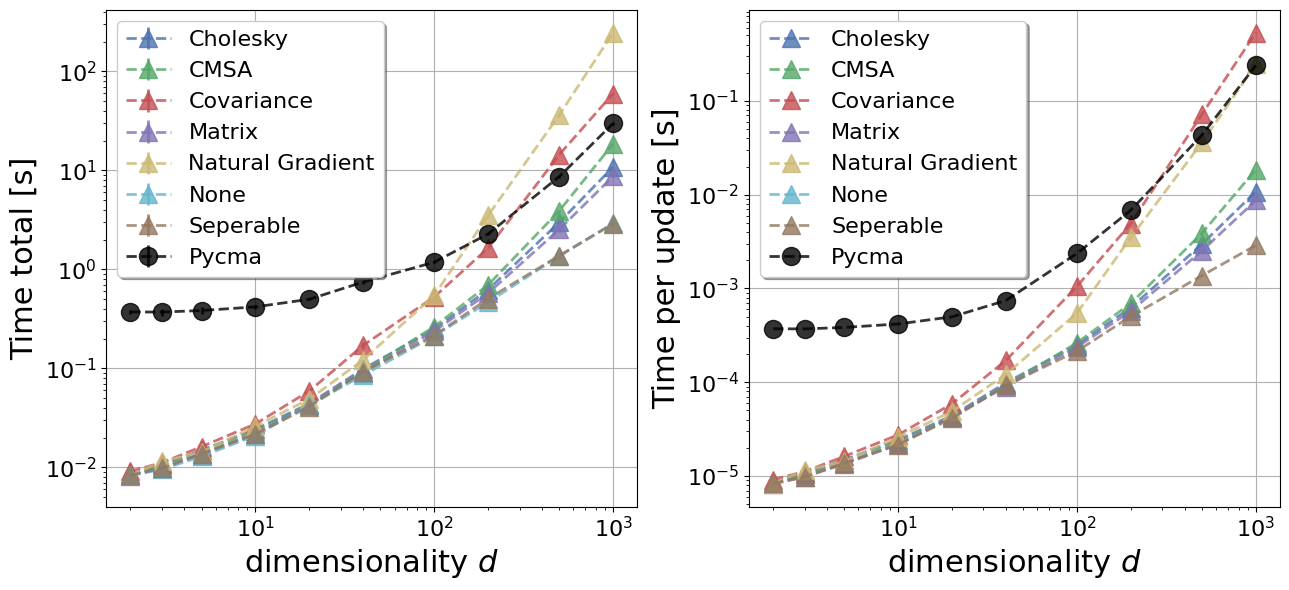

In [2]:
stats = pd.read_csv("time_stats.csv")
stats_pycma = pd.read_csv("time_stats_pycma.csv")
stats = pd.concat([stats, stats_pycma])


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

n = np.arange(2, 1000)
c = 0.01

colors = [
    "#4C72B0",  # blue
    "#55A868",  # green
    "#C44E52",  # red
    "#8172B3",  # purple
    "#CCB974",  # yellow-brown
    "#64B5CD",  # cyan
    "#937860",  # brown-gray
    "#000000"
]

colormap = {}
for (method, group), color in zip(stats.groupby("method", sort=True), colors):
    colormap[method] = color
    label = method.title().replace("_", " ") if method != "CMSA" else method

    time_gb = group.groupby("dim")['time']
    marker = "^"
    if method == "pycma":
        marker = 'o'
    plot_dat = pd.merge(
        time_gb.apply(lambda x: np.exp(np.mean(np.log(x)))).rename("mean"), 
        time_gb.std().rename("std"),
        on="dim"
    ).merge(group.groupby("dim")['n_updates'].mean().rename("n_updates"), on="dim")

    ax1.errorbar(
        plot_dat.index, plot_dat['mean'], plot_dat['std'],
        label=label, 
        marker=marker,
        markersize=13,
        linestyle='dashed',
        alpha=.8,
        linewidth=2,
        color=color
    )

    ax2.plot(
        plot_dat.index, plot_dat['mean'] / plot_dat['n_updates'], 
        label=label, 
        marker=marker,
        markersize=13,
        linestyle='dashed',
        alpha=.8,
        linewidth=2,
        color=color
    )

for ax in ax1, ax2:
    ax.grid(which="major")
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=10)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize=16, ncol=1, fancybox=True, shadow=True) 
    ax.set_xlabel(r"dimensionality $d$", fontsize=22)

ax1.set_ylabel("Time total [s]", fontsize=22)
ax2.set_ylabel("Time per update [s]", fontsize=22)
plt.tight_layout()
plt.savefig("time_matrix_adaptation.png", dpi=500)

In [3]:
import os
from iohinspector import DataManager

data_path = "/home/jacob/code/ModularCMAES/data"
data_folders = [os.path.join(data_path, folder) for folder in os.listdir(data_path)]
manager = DataManager()
for folder in data_folders:
    if os.path.isdir(folder):
        manager.add_folder(folder)


completed = manager.overview.group_by(["algorithm_name", "function_id", "dimension"]).len().filter(len=100)
completed_overview = manager.overview.join(
    completed,
    on=["algorithm_name", "function_id", "dimension"],
    how="inner"
)

def ert(runs, target = 1e-8):
    total_evals = 0
    n_suc = 0
    for row in runs.iter_rows(named=True):
        total_evals += row['evals']
        if row['best_y'] <= target:
            n_suc += 1

    if n_suc <= 0:
        return float("inf")
    return total_evals / n_suc

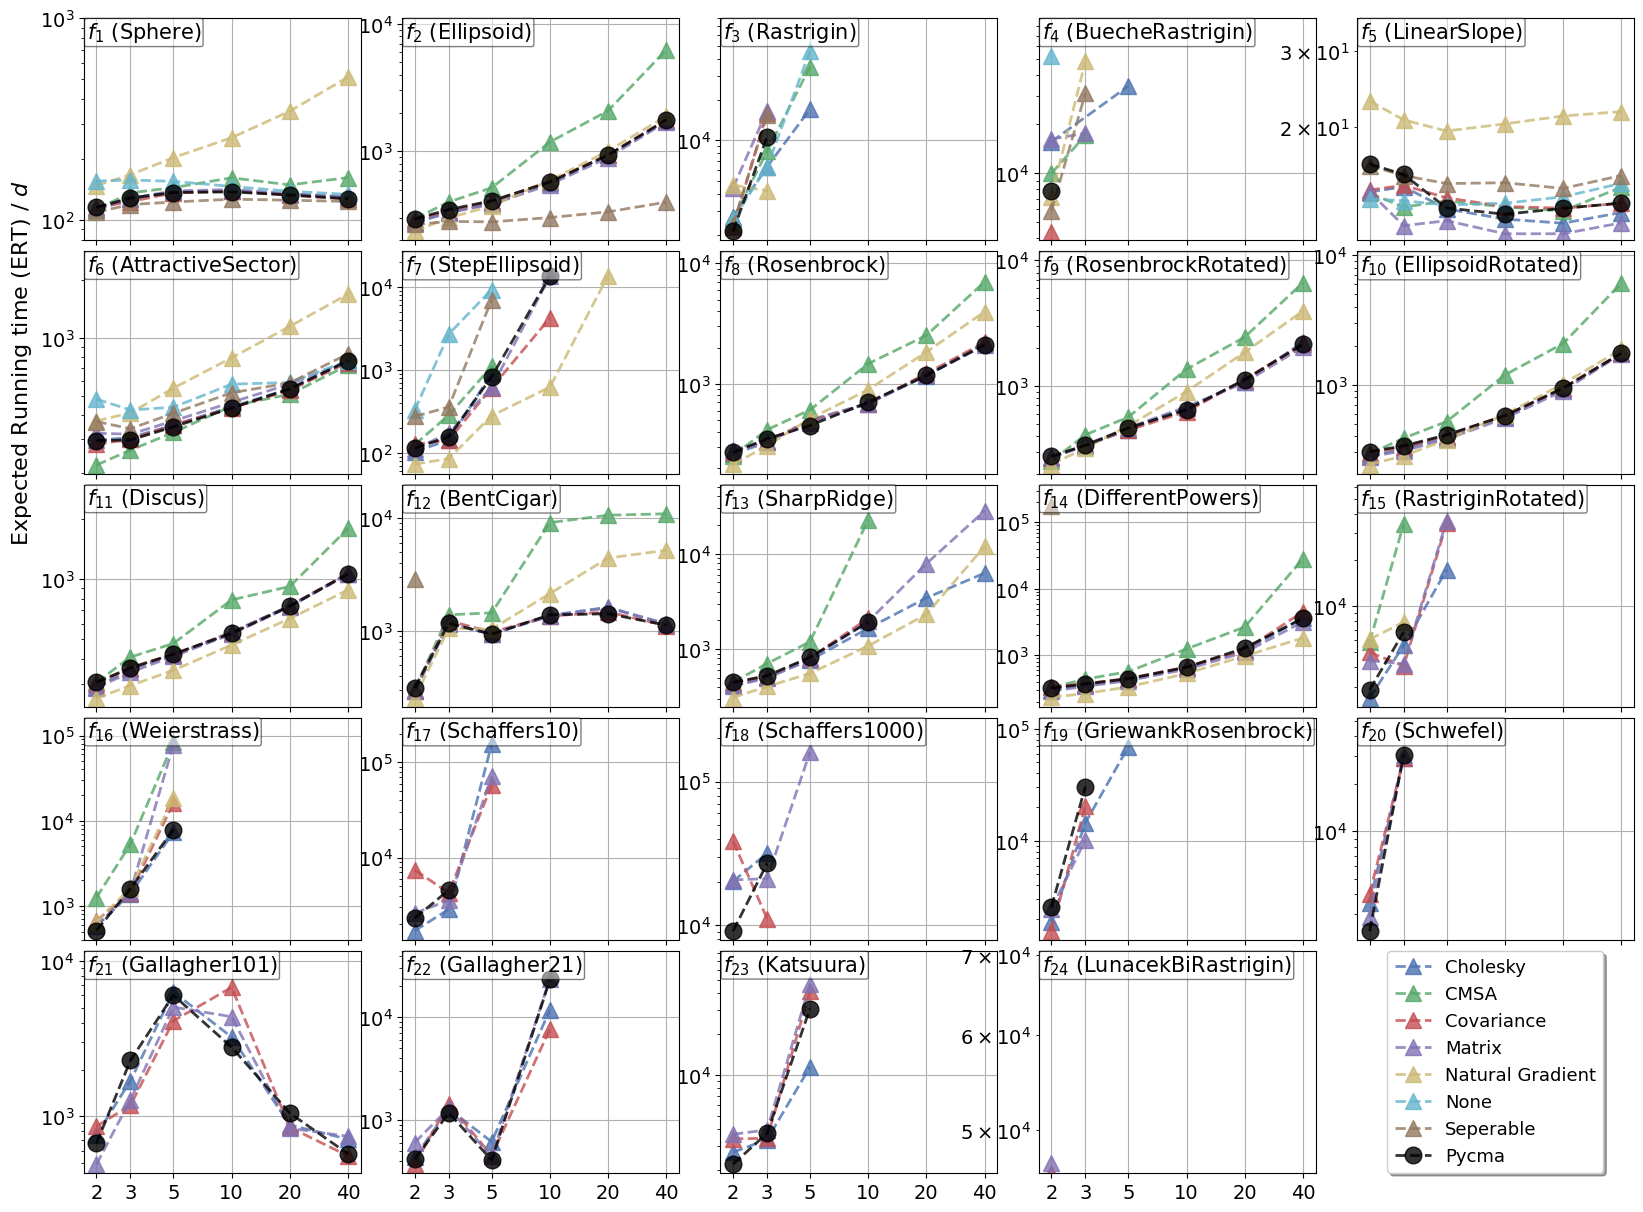

In [21]:

DIMS = np.array([2, 3, 5, 10, 20, 40, 100])
FUNCTIONS = np.arange(1, 25)


f, axes = plt.subplots(5, 5, figsize=(20, 15), sharex='col', sharey=False)
axes = axes.ravel()
for (fid, ax) in zip(FUNCTIONS, axes):
    f_data = completed_overview.filter(function_id = fid)

    for method, color in colormap.items():
        m_data = f_data.filter(algorithm_name = method)
        erts = np.array([ert(m_data.filter(dimension=d)) / d for d in DIMS]) 
        label = method.title().replace("_", " ") if method != "CMSA" else method
        marker = "^"
        if method == "pycma":
            marker = 'o'
        mask = np.isfinite(erts)
        ax.plot(
            DIMS[mask], 
            erts[mask], 
            label=label, 
            marker=marker,
            markersize=12,
            linestyle='dashed',
            alpha=.8,
            linewidth=2,
            color=color
        )

    ax.grid(which="both", axis='x')
    ax.grid(which="major", axis='y')
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    ax.set_xticks(DIMS[:-1], DIMS[:-1])
    ax.tick_params(axis='both', which='both', labelsize=14)
    
    ax.text(0.01, 0.99,f"$f_{{{fid}}}$ (" + f_data['function_name'][0] + ")",
        transform=ax.transAxes,
        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5),
         ha='left', va='top', fontsize=15)

    if fid == 6:
        ax.set_ylabel("Expected Running time (ERT) / $d$", fontsize=16)
        
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1.5 * ylim[1])
    if fid == 1:
        ax.set_ylim(10**1.9, 10**3)

    if fid == 12:
        ax.set_xlabel(f"Dimensionality $d$", fontsize=16)

axes[24].axis('off')
handles, labels = axes[0].get_legend_handles_labels()
axes[24].legend(handles, labels, loc='center', fancybox=True, shadow=True, fontsize=13)
# plt.tight_layout()
plt.subplots_adjust(hspace=.05, wspace=0.15)


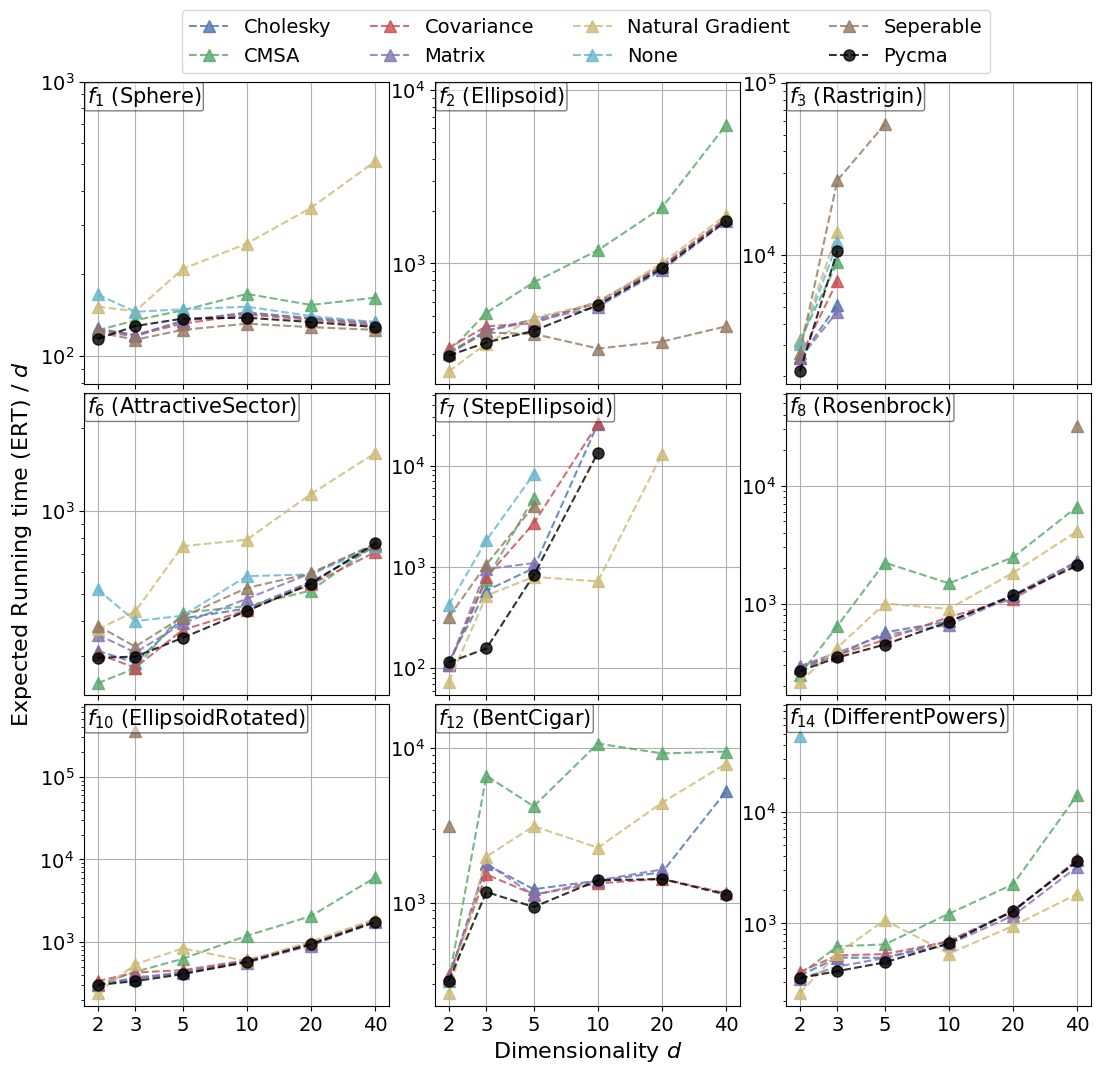

In [ ]:



DIMS = np.array([2, 3, 5, 10, 20, 40, 100])
FUNCTIONS = np.arange(1, 25)

FUNCTIONS = [1, 2, 3, 6, 7, 8, 10, 12, 14]
# colormap['COVARIANCE-2'] = 'blue'


f, axes = plt.subplots(3, 3, figsize=(13, 12), sharex='col', sharey=False)

for (fid, ax) in zip(FUNCTIONS, axes.ravel()):
    f_data = completed_overview.filter(function_id = fid)

    for method, color in colormap.items():
        m_data = f_data.filter(algorithm_name = method)
        erts = np.array([ert(m_data.filter(dimension=d)) / d for d in DIMS]) 
        label = method.title().replace("_", " ") if method != "CMSA" else method
        marker = "^"
        if method == "pycma":
            marker = 'o'
        mask = np.isfinite(erts)
        ax.plot(
            DIMS[mask], 
            erts[mask], 
            label=label, 
            marker=marker,
            markersize=8,
            linestyle='dashed',
            alpha=.8,
            linewidth=1.5,
            color=color
        )

    ax.grid(which="both", axis='x')
    ax.grid(which="major", axis='y')
    ax.set_yscale("log", base=10)
    ax.set_xscale("log", base=2)
    ax.set_xticks(DIMS[:-1], DIMS[:-1])
    ax.tick_params(axis='both', which='both', labelsize=14)
    
    ax.text(0.01, 0.99,f"$f_{{{fid}}}$ (" + f_data['function_name'][0] + ")",
        transform=ax.transAxes,
        bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.5),
         ha='left', va='top', fontsize=15)

    if fid == 6:
        ax.set_ylabel("Expected Running time (ERT) / $d$", fontsize=16)
        
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1.5 * ylim[1])
    if fid == 1:
        ax.set_ylim(10**1.9, 10**3)

    if fid == 1:
        ax.legend(ncol=4, fontsize=14, bbox_to_anchor=(3, 1.27))

    if fid == 12:
        ax.set_xlabel(f"Dimensionality $d$", fontsize=16)

plt.subplots_adjust(hspace=.03, wspace=0.15)
plt.savefig("selected_benchmarks.png", dpi=500)


In [ ]:
completed_overview

data_id,algorithm_name,algorithm_info,suite,function_name,function_id,dimension,instance,run_id,evals,best_y,len
u64,str,str,str,str,u16,u16,u16,u32,u64,f64,u32
36034,"""COVARIANCE""","""algorithm_info""","""unknown_suite""","""RosenbrockRotated""",9,2,1,1,588,4.8342e-9,100
36035,"""COVARIANCE""","""algorithm_info""","""unknown_suite""","""RosenbrockRotated""",9,2,1,2,462,9.7663e-9,100
36036,"""COVARIANCE""","""algorithm_info""","""unknown_suite""","""RosenbrockRotated""",9,2,1,3,528,8.7072e-9,100
36037,"""COVARIANCE""","""algorithm_info""","""unknown_suite""","""RosenbrockRotated""",9,2,1,4,666,4.7348e-9,100
36038,"""COVARIANCE""","""algorithm_info""","""unknown_suite""","""RosenbrockRotated""",9,2,1,5,522,3.7224e-9,100
…,…,…,…,…,…,…,…,…,…,…,…
4796,"""MATRIX""","""algorithm_info""","""unknown_suite""","""Discus""",11,40,1,96,45030,9.5771e-9,100
4797,"""MATRIX""","""algorithm_info""","""unknown_suite""","""Discus""",11,40,1,97,10846,348.159048,100
4798,"""MATRIX""","""algorithm_info""","""unknown_suite""","""Discus""",11,40,1,98,22306,304.009028,100
